<a href="https://colab.research.google.com/github/MevrouwHelderder/final_assignment/blob/main/Final_Assignment_Energy_production_and_consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final assignment - Energy production and consumption



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%load_ext google.colab.data_table

In [2]:
path_base = "https://raw.githubusercontent.com/MevrouwHelderder/final_assignment/main/"

paths = {
    "energy_total" : path_base + "owid-energy-data.csv",
    "co2_greenhouse" : path_base + "owid-co2-data.csv",
    "net_zero_pledge" : path_base + "net-zero-targets.csv",
    # "agri_land_use_total" : path_base + "total-agricultural-area-over-the-long-term.csv",
    # "grazing" : path_base + "grazing-land-use-over-the-long-term.csv",
    # "cropland" : path_base + "cropland-use-over-the-long-term.csv"
}

dataframes = {}

for key, value in paths.items():
  dataframes[key] = pd.read_csv(value)

energy_total_df = dataframes["energy_total"]
co2_greenhouse_df = dataframes["co2_greenhouse"]
net_zero_pledge_df = dataframes["net_zero_pledge"]
# agri_land_use_total_df = dataframes["agri_land_use_total"]
# grazing_df = dataframes["grazing"]
# cropland_df = dataframes["cropland"]

# Exploration
Let's first explore the datasets to see what we are working with.
It might also be better to weed out data that is not needed now and perhaps combine data that is needed.

In [3]:
# the CO2 dataframe
# selecting the needed columns, changing the index
explore_co2 = co2_greenhouse_df.loc[:, ["country", "year", "iso_code", "population", "co2", "co2_growth_abs", "co2_growth_prct", "co2_per_capita", "trade_co2", "consumption_co2", "consumption_co2_per_capita" ]]
explore_co2 = explore_co2.set_index("year")
explore_co2.index = pd.to_datetime(explore_co2.index, format="%Y", errors="coerce")

# show only the true countries, not the combinations like continents
explore_co2 = explore_co2[~explore_co2["iso_code"].isnull()]


In [4]:
# pledge dataframe
net_zero_pledge_df.rename(columns={'Entity': 'country', 'Code': 'iso_code', 'Year' :'pledged_year', 'Status of net-zero target': 'status'}, inplace=True)

In [5]:
# The energy dataframe
# Renaming column names so there is more uniformity
for column in energy_total_df.columns:
    if "_share_elec" in column:
        new_name = column.replace("_share_elec", "_share_gen")
        energy_total_df.rename(columns={column: new_name}, inplace=True)
    if "_share_energy" in column: 
        new_name = column.replace("_share_energy", "_share_cons")
        energy_total_df.rename(columns={column: new_name}, inplace=True)
    if "_elec_per_capita" in column: 
        new_name = column.replace("_elec_per_capita", "_gen_per_capita")
        energy_total_df.rename(columns={column: new_name}, inplace=True)
    if "_electricity" in column: 
        new_name = column.replace("_electricity", "_gen")
        energy_total_df.rename(columns={column: new_name}, inplace=True)
    if "_energy_per_capita" in column: 
        new_name = column.replace("_energy_per_capita", "_cons_per_capita")
        energy_total_df.rename(columns={column: new_name}, inplace=True)     
    if "_cons_per_capita" in column: 
        new_name = column.replace("_cons_per_capita", "_cons_per_capita")
        energy_total_df.rename(columns={column: new_name}, inplace=True)       

energy_total_df.rename(columns={"other_renewable_consumption": "other_renewables_consumption","other_renewables_gen_per_capita_exc_biofuel" :"other_renew_exc_biofuel_gen_per_capita",
                             "other_renewables_share_gen_exc_biofuel": "other_renew_exc_biofuel_share_gen", 'other_renewable_gen' : 'other_renewables_gen', 'other_renewable_exc_biofuel_gen' : 'other_renewables_exc_biofuel_gen'
}, inplace=True)

# Setting the index
energy_total_df = energy_total_df.set_index("year")
energy_total_df.index = pd.to_datetime(energy_total_df.index, format="%Y", errors="coerce")

# show only the true countries, not the combinations like continents
energy_total_df = energy_total_df[~energy_total_df["iso_code"].isnull()]


* **wind, solar, hydro, biofuel, other renewables exc biofuel, nuclear, coal, oil and gas** are exclusive energy sources

* **renewables** is the sum of wind, solar, hydro, biofuel, other renewables exc biofuel
* **low_carbon** is the sum of wind, solar, hydro, biofuel, other renewables exc biofuel and nuclear
* **fossil** could be the sum of coal, oil and gas, I can make a column for that


# Making dataframes with just the information needed.
Since the original dataframe is huge, both column- and rowwise, I want to make new dataframes with only the information I need per type of energy.
All columns are named following a pattern so I can use that to my advantage.

In [6]:
# Renewables:
renew_list = ['wind', 'solar', 'hydro', 'biofuel']

# Fossil:
fossil_list = ['coal', 'oil', 'gas']

# low_carbon:
low_carbon_list = ['wind', 'solar', 'hydro', 'biofuel', 'nuclear']

# totals:
totals_list = ['renewables', 'low_carbon']

# base column name format: 
base_list = ['_consumption', '_cons_per_capita', '_gen', '_gen_per_capita']

# columns that won't work with the function: 
manual = ['other_renew_exc_biofuel_gen_per_capita', 'other_renewables_exc_biofuel_gen']

# function to create a new list from a list of topics and a list of measurements
def combine_lists(topic_list, measurement_list):
    new_columns = ['country', 'iso_code', 'population', 'gdp']
    for topic_item in topic_list:
        for measurement_item in measurement_list:
            new_columns.append(topic_item + measurement_item)
    return new_columns

# creating the column names
renewables_columns = (combine_lists(renew_list, base_list)) + manual
fossils_columns = combine_lists(fossil_list, base_list)
low_carbon_columns = (combine_lists(low_carbon_list, base_list)) + manual
totals_columns = combine_lists(totals_list, base_list)

In [7]:
# making the dataframes
renewables_df = energy_total_df.loc[:,renewables_columns]
fossils_df = energy_total_df.loc[:,fossils_columns]
low_carbon_df = energy_total_df.loc[:,low_carbon_columns]
totals_df = energy_total_df.loc[:,totals_columns]

In [8]:
# creating a new column in the totals dataframe that combines all the fossil fuels
totals_df['fossil_consumption'] = energy_total_df['coal_consumption']+ energy_total_df['gas_consumption']+ energy_total_df['oil_consumption']
totals_df['fossil_gen'] = energy_total_df['coal_gen']+ energy_total_df['gas_gen']+ energy_total_df['oil_gen']
totals_df['fossil_cons_per_capita'] = energy_total_df['coal_cons_per_capita']+ energy_total_df['gas_cons_per_capita']+ energy_total_df['oil_cons_per_capita']
totals_df['fossil_gen_per_capita'] = energy_total_df['coal_gen_per_capita']+ energy_total_df['gas_gen_per_capita']+ energy_total_df['oil_gen_per_capita']

# Adding columns with all tot complete totals
totals_df['total_consumption'] = energy_total_df['primary_energy_consumption']
totals_df['total_cons_per_capita'] = energy_total_df['energy_per_capita']
totals_df['total_gen'] = energy_total_df["electricity_generation"]
totals_df['total_gen_per_capita'] = energy_total_df['per_capita_gen']

In [9]:
# Changing 0 to NaN to prevent infinity
no_zero_totals_df = totals_df.replace (0, np.nan)

# Interesting!
It shows that countries that produce a lot of CO2 do not nececarily produce that for their own use. 
And also: countries that produce a high amount of CO2 per capita for their own use are not the countries that produce a lot of CO2 in general.

# Now let's see how the energy consumption and production of countries changed over time

In [10]:
# Using the dataframe as is gave a lot of NaN's because of missing values.
# Interpolating to get a better result: 
interpolate_df = no_zero_totals_df.copy(deep=True)

# Function to resample and interpolate
def prepare(df):
    df = (
        df.groupby('country')
        .resample('YS')
        .mean(numeric_only=True)
        .interpolate(method='linear')
    )
    df.reset_index(inplace=True)
    df.set_index('year', inplace=True)

    return df
interpolate_df = prepare(interpolate_df)

# Decide which columns to use
interpolate_numeric_columns = interpolate_df.select_dtypes(include=np.number).head(5)
interpolate_numeric_columns = interpolate_numeric_columns.columns.tolist()

# Calculate the first and last available years for each country
interpolate_first_year = interpolate_df.groupby('country').first()
interpolate_last_year = interpolate_df.groupby('country').last()

# Create a new DataFrame to store the percentage change between the first and last available years
change_df = ((interpolate_last_year[interpolate_numeric_columns] - interpolate_first_year[interpolate_numeric_columns]) / interpolate_first_year[interpolate_numeric_columns] * 100).round(3)
change_df.dropna(inplace=True)

# Renaming the columns
new_columns = [col + '_%_change' for col in change_df.columns]
change_df.rename(columns=dict(zip(change_df.columns, new_columns)), inplace=True)

In [11]:
# Splitting up into two dataframes
general_columns = ["population_%_change", "gdp_%_change"]
per_capita_columns = change_df.filter(like="capita").columns
per_capita_and_general_columns = general_columns + list(per_capita_columns)

In [12]:
change_per_capita_df = change_df.loc[:,per_capita_and_general_columns ]
change_df = change_df.drop(per_capita_columns, axis=1)

In [13]:
change_per_capita_df.head(5)

,population_%_change,gdp_%_change,renewables_cons_per_capita_%_change,renewables_gen_per_capita_%_change,low_carbon_cons_per_capita_%_change,low_carbon_gen_per_capita_%_change,fossil_cons_per_capita_%_change,fossil_gen_per_capita_%_change,total_cons_per_capita_%_change,total_gen_per_capita_%_change
country,,,,,,,,,,
Algeria,847.208,1836.432,-57.603,-98.871,-57.603,-98.871,709.135,1843.970,40.661,-4.460
American Samoa,36.915,-44.022,39.766,47.191,39.766,47.191,-0.615,99.192,-43.368,97.024
Angola,999.450,-45.122,83.389,1006.316,83.389,1006.316,-1.827,-96.184,-84.902,-86.460
Antarctica,-97.312,-41.499,14.601,-34.946,14.601,-34.946,-0.600,680.692,417.013,177.952
Antigua and Barbuda,43.635,-75.957,13.351,-1.352,13.351,-1.352,-0.635,172.813,24.184,166.331


In [14]:
change_df.head(5)

,population_%_change,gdp_%_change,renewables_consumption_%_change,renewables_gen_%_change,low_carbon_consumption_%_change,low_carbon_gen_%_change,fossil_consumption_%_change,fossil_gen_%_change,total_consumption_%_change,total_gen_%_change
country,,,,,,,,,,
Algeria,847.208,1836.432,51.226,-82.619,51.226,-82.619,2787.082,3348.977,2024.097,1338.329
American Samoa,36.915,-44.022,13.427,-0.315,13.427,-0.315,-6.900,-99.781,5.182,-99.783
Angola,999.450,-45.122,34.836,1201.002,34.836,1201.002,-21.911,2734.121,1735.158,9436.954
Antarctica,-97.312,-41.499,8.309,-51.955,8.309,-51.955,-9.065,-63.003,-91.200,-64.437
Antigua and Barbuda,43.635,-75.957,8.050,-99.632,8.050,-99.632,-10.507,-79.530,641.956,-93.614




---



---



---



# What are the safest and cleanest?

https://ourworldindata.org/safest-sources-of-energy#the-safest-energy-sources-are-also-the-cleanest

# Let's look at the top tens of countries when it comes to the output of CO2:
since not all data was available for the years after 2020 I will use 2020.

<Axes: title={'center': 'Total CO2 production'}, ylabel='country'>

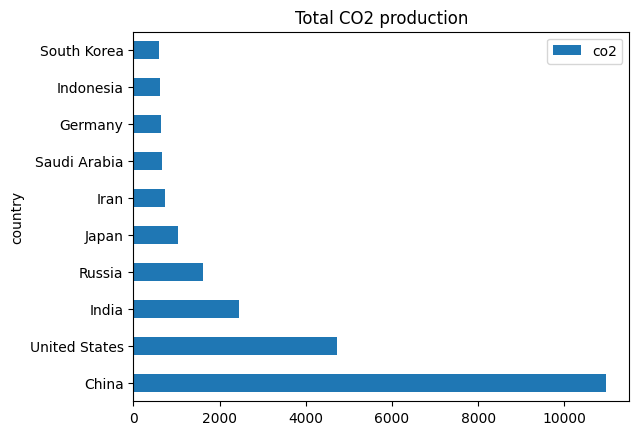

In [15]:
# Total production, not corrected for trade :
top_co2_2020 = explore_co2.loc['2020-01-01 00:00:00',['country', 'co2']].sort_values(by='co2', ascending = False).set_index('country').head(10)
top_co2_2020.plot.barh(title='Total CO2 production')

<Axes: title={'center': 'Total CO2 production per capita'}, ylabel='country'>

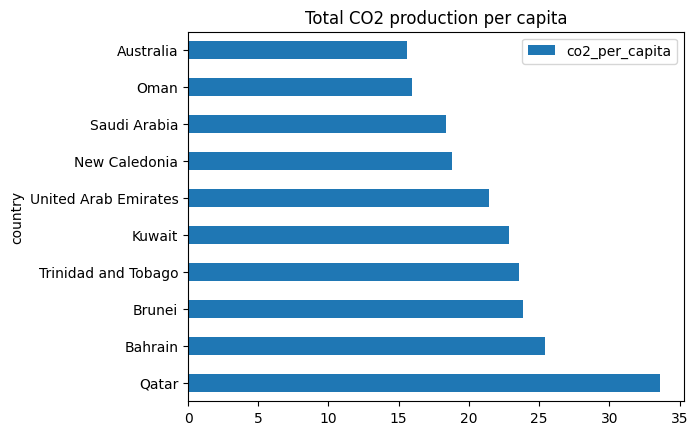

In [16]:
# Total production per capita, not corrected for trade :
top_co2_pc_2020 = explore_co2.loc["2020-01-01 00:00:00",["country", "co2_per_capita"]].sort_values(by="co2_per_capita", ascending = False).set_index('country').head(10)
top_co2_pc_2020.plot.barh(title='Total CO2 production per capita')

<Axes: title={'center': 'Total CO2 production for own consumption'}, ylabel='country'>

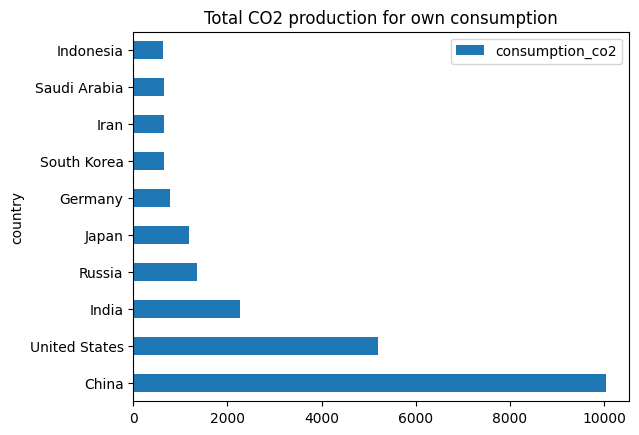

In [17]:
# Total co2 for own consumption: 
top_co2_consumer_2020 = explore_co2.loc["2020-01-01 00:00:00",["country", "consumption_co2"]].sort_values(by="consumption_co2", ascending = False).set_index('country').head(10)
top_co2_consumer_2020.plot.barh(title='Total CO2 production for own consumption')

<Axes: title={'center': 'Total CO2 production per capita for own consumption'}, ylabel='country'>

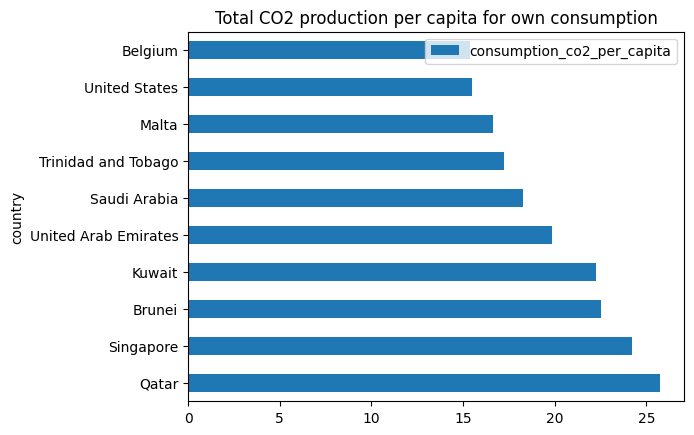

In [18]:
# Total co2 for own consumption per capita: 
top_co2_consumer_pc_2020 = explore_co2.loc["2020-01-01 00:00:00", ["country", "consumption_co2_per_capita"]].sort_values(by="consumption_co2_per_capita", ascending = False).set_index('country').head(10)
top_co2_consumer_pc_2020.plot.barh(title='Total CO2 production per capita for own consumption')

This is your final assignment. You'll get a lot of freedom in doing this assignment but that also means you have to make choices and explain the reasoning behind those choices in your report.

For this assignment you can use any dataset you can find from the [Our World in Data website](https://ourworldindata.org/).

Please formulate an answer to the following three questions in your report.

* **What is the biggest predictor of a large CO2 output per capita of a country?**
* **which countries are making the biggest strides in decreasing CO2 output?**
* **which non-fossil fuel energy technology will have the best price in the future?**




---


**1: Biggest predictor of CO2 output**

To determine this you may want to consider things like GDP per capita, diets, number of cars per capita, various energy source, mobility and other factors.

Your answer can also be a specific combination of certain factors.


---


**2: Biggest strides in decreasing CO2 output**

You'll need to find the relative CO2 output for each country to be able to calculate this. But countries can have growing and shrinking populations too, so it's probably a good idea to take this into account as well.


---


**3: Best future price for non-fossil fuel energy**

To be able to predict prices you'll probably need to use linear regression over the various non-fossil fuel options.


---


**Submitting your Assignment**

Once you're done with this module, you can go to the next item where you'll be able to submit your assignment.

Please submit both your written report and all notebooks you've created in creating the report. Make sure everything works before submitting.



# Thoughts: 
**For the biggest predictor of a large CO2 output per capita of a country, you can use the following datasets:**

* CO2 emissions by country: This dataset provides historical CO2 emissions data for different countries over time.
* Energy consumption by fuel type: This dataset shows the energy consumption of different countries categorized by fossil fuels (coal, oil, gas), renewables, and other sources.
* Population by country: This dataset provides population data for different countries over time.

By combining these datasets, you can calculate CO2 emissions per capita and analyze the relationship between various factors like energy consumption, population, and CO2 emissions.

**To identify the countries making the biggest strides in decreasing CO2 output, you can use the following datasets:**

* CO2 emissions by country: This dataset will be useful again to track changes in CO2 emissions over time.
* Annual change in CO2 emissions: This dataset provides the annual percentage change in CO2 emissions for different countries.
* Renewable energy production: This dataset includes information on the production of renewable energy, such as solar, wind, hydro, and geothermal.

By analyzing the annual change in CO2 emissions and comparing it with the growth in renewable energy production, you can identify countries that are successfully reducing their CO2 output.

**For determining the non-fossil fuel energy technology with the best price in the future, you can consider the following datasets:**

* Costs of different energy technologies: This dataset provides information on the costs of various energy technologies, including solar, wind, hydro, nuclear, and others. It can help you analyze the trends and projections for future energy costs.
* Renewable energy capacity and investment: This dataset shows the installed capacity and investment trends in renewable energy sources, which can provide insights into the growth potential and competitiveness of different technologies.

By examining the cost trends and comparing the capacity and investment data, you can assess which non-fossil fuel energy technology is expected to have the most favorable price in the future.


**Find what countries do:**

* did they make any pledges
* what kind of energy are they using now


* What contributes to CO2 output?

* What are the prices for the different types of non-fossil energy?

* What happens when a country outsources everything?

* How about CO2 vs the other GHG (greenhouse gasses)? Are there countries where CO2 falls but the other rise?

# 1: Biggest predictor of CO2 output

# 2: Biggest strides in decreasing CO2 output

First let's look at what countries produces, import, export and how that changed through the years.

* **co2**: annual total production-based co2 emission. measured in million tonnes. Measured in million tonnes.
* **co2_growth_abs**: annual growth of production-based co2 emission. Measured in million tonnes.
* **co2_growth_prct**: annual percentage growth of production-based co2 emission. measured in million tonnes. Measured in million tonnes.
* **co2_per_capita**, annual total production-based emissions of carbon dioxide (CO₂) per capita, measured in tonnes per person. 

* **trade_co2**: annual net carbon dioxide (CO₂) emissions embedded in trade. The net of import or export via traded goods. Positive = importer of CO₂ emissions; Negative =  exporter. Measured in million tonnes.
* **consumption_co2**: total co2 minus emissions embedded in exports, plus emissions embedded in imports. Consumption > production = importer of CO₂ emissions; Consumption < Production =  exporter. Measured in million tonnes.
* **consumption_co2**: total co2 minus emissions embedded in exports per capita, plus emissions embedded in imports. Consumption > production = importer of CO₂ emissions; Consumption < Production =  exporter. Measured in tonnes per person.

Note for later: 
also interesting: 
* what do we see when we look at rich vs poor (columns regarding GDP)
* what do we see when we look at the CO2 per energy unit.